## Uncalibrated Stereo Camera Settings

![img](img/uncalibrated_epipolar_constraint.png)

임의의 두 카메라가 한 물체를 바라보고 있다면, intrinsic과 extrinsic 정보와는 무관하게 epipolar plane에 수직인 normal vector에서 도출된 식인 epiploar constraint, x_left E x_right = 0이 성립한다. (E=essential matrix)

### 단계
1) 카메라 intrinsic matrix를 구한다.
2) 왼쪽 이미지와 오른쪽 이미지에 대한 특징점 검출을 시행한다. (SIFT 사용)
3) epipolar constraint 식에 대입하여, Fundamental Matrix를 구한다. (Least Square Method : Af = 0)
4) Intrinsic matrix (K_l과 K_r)을 대입하여 Essential Matrix를 구한다. (K_l^T F K_r = E)
5) E=TxR. T(left 카메라의 원점으로부터 right 카메라 원점의 translation)와 R(left 카메라의 회전 정도를 나타내는 matrix)를 구한다. (Singular Vector Decomposition 사용)

### cv2 코드

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
left_img = cv2.imread('uncalibrated_images/uncalibrated_left1.jpg')
right_img = cv2.imread('uncalibrated_images/uncalibrated_right1.jpg')


### 카메라 정보
![카메라 정보](img/카메라정보.png)![카메라 정보 설명](img/카메라정보_설명.png)

In [ ]:
fx = 1.6
fy = 1.6
ox = 3024//2 ## principal point로부터 top-left corner까지의 거리
oy = 4032//2 

intrinsic_matrix = np.array([[fx, 0, ox],
                             [0, fy, oy],
                             [0, 0 ,  1]])

## https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html 링크로 확인하기. 체크보드는 직접?

In [79]:
## 매트릭스를 사용한 이미지 변환 방식. homogenous 좌표를 사용한다.
## 출처 : https://towardsdatascience.com/image-geometric-transformation-in-numpy-and-opencv-936f5cd1d315

def get_grid(x, y, homogenous = False) :
    coords = np.indices((y,x)).reshape(2,-1)
    return np.vstack([coords, np.ones(coords.shape[1])]) if homogenous else coords

samp_img = plt.imread('uncalibrated_images/uncalibrated_left1.jpg')


In [80]:
image = samp_img

height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 1

R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])

T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])

S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])

A = T@R@S@np.linalg.inv(T)

Ainv = np.linalg.inv(A)

# Grid to represent image coordinate I(x, y)
coords = get_grid(width, height, True)
x1, y1 = coords[0], coords[1]

# Apply transformation and nearest neighbor interpolation
warp_coords = np.round(A@coords).astype(int)
x2, y2 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image
indices = np.where((x2 >= 0) & (x2 < width-1) &
                   (y2 >= 0) & (y2 < height-1))

xpix2, ypix2 = x2[indices], y2[indices]
xpix1, ypix1 = x1[indices], y1[indices]

# Copy values to new image I'(x, y)
canvas = np.zeros_like(image)
canvas[np.clip(np.int32(ypix2), 0, height-1), np.clip(np.int32(xpix2), 0, width-1)] = image[np.clip(np.int32(ypix1), 0, height-1), np.clip(np.int32(xpix1), 0 , width-1)]



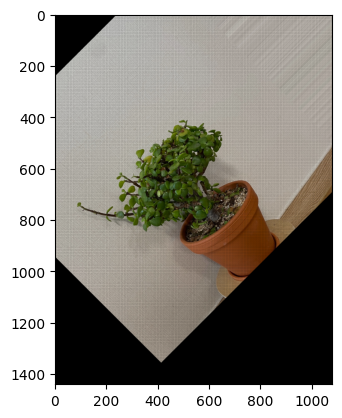

In [73]:
plt.imshow(canvas)

In [78]:
## SIFT 연산

(array([    496,     497,     498, ..., 1542833, 1543911, 1543912],
       dtype=int64),)

In [76]:
x2.shape

(1555200,)